<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/ml_analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import os

!pip install -U dtreeviz
import dtreeviz

from google.colab import files

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 988.2 kB/s eta 0:00:00


#Function definitions

##plot_confusion_matrix

In [2]:
def plot_confusion_matrix(cm, model):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(
        width=500,
        height=500,
        title=model+' Confusion Matrix',
        font_size=16,
        template='plotly_dark'
        )
    fig.show()
    return fig

##plot_roc_curve

**pogrubiony tekst**
 Receiver Operating Characteristic
1. True Positive Rate (TPR) = FP / (FP+TN)
2. False Positive Rate (FPR) = TP / (TP+FN)

In [3]:
def plot_roc_curve(y_test, y_pred, model):
    # Binary classification
    from sklearn.metrics import roc_curve
    fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)

    fig = go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr,
                    line_color='red',
                    name='ROC Curve'),
            go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    line_dash='dash',
                    line_color='#F012BE')
        ],
        layout=go.Layout(xaxis_title='False Positive Rate',
                         yaxis_title='True Positive Rate',
                         title = model + ' ROC Curve',
                         showlegend=False,
                         template='plotly_dark',
                         width=700))
    fig.show()
    return fig


##model_validation


Precision (precyzja) = TP / (TP+FP): Ile obserwacji przewidzianych jako pozytywne jest w rzeczywistości pozytywne.

Recall (czułość) = TP / (TP+FN): Ile obserwacji z wszystkich pozywtywnych sklasyfikowaliśmy jako pozytywne.

F1-score: ważona średnia harmonicza między precyzją a czułością;

Support (wsparcie): liczba próbek, które należą do każdej z klas;

Accuracy (dokładność) = (TP+TN) /(TP+TN+FP+FN))

FPR (False Positive Rate) = FP / (FP+TN) [type I error]

FNR (False Negative Rate) = FN / (FN+TP) [type II error]

In [4]:
def model_validation(y_test, y_pred, model):
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average="weighted")
  recall = recall_score(y_test, y_pred, average="weighted")
  f1 = f1_score(y_test, y_pred, average="weighted")
  roc_score = roc_auc_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()
  fpr = fp / (fp + tn) # False Positive Rate - Type I error
  fnr = fn / (fn + tp) # False Negative Rate - Type II error

  model_results = pd.DataFrame([{'accuracy': accuracy,
                                 'precision': precision,
                                 'recall': recall,
                                 'f1': f1,
                                 'AUROC': roc_score,
                                 'fpr': fpr,
                                 'fnr': fnr
                                 }],
                                  index=[str(model)]
                               )
  return model_results

##plot_learning_curve

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Data exploration

In [6]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/cleaned_samobojstwa_2013_2022.csv', delimiter=',', low_memory=False)

In [7]:
df_raw.head(5)

,ID_samobójcy,Data_raportu,Przedział_wiekowy,Płeć,Stan_cywilny,Wykształcenie,Informacje_o_pracy_i_nauce,Źródło_utrzymania,Czy_samobójstwo_zakończyło_się_zgonem,Miejsce_zamachu,Sposób_popełnienia,Stan_świadomości,Informacje_o_używaniu_substancji,Informacje_dotyczące_leczenia_z_powodu_alkoholizmu/narkomanii,Data_raportu_rok,Data_raportu_miesiąc,Liczba_powodów_zamachu,Powód_zamachu_Nieporozumienie rodzinne/przemoc w rodzinie,Powód_zamachu_Choroba psychiczna/zaburzenia psychiczne,Powód_zamachu_Problemy w szkole lub pracy,Powód_zamachu_Choroba fizyczna,Powód_zamachu_Nagła utrata źródła utrzymania,Powód_zamachu_Złe warunki ekonomiczne/długi,Powód_zamachu_Pogorszenie lub nagła utrata zdrowia,Powód_zamachu_Niepożądana ciąża,"Powód_zamachu_Mobbing, cybermobbing, znęcanie",Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,Powód_zamachu_Inny niewymieniony,Powód_zamachu_Przewlekła choroba,Powód_zamachu_Dokonanie przestępstwa lub wykroczenia,Powód_zamachu_Śmierć bliskiej osoby,Powód_zamachu_Konflikt z osobami spoza rodziny,"Powód_zamachu_Nosiciel wirusa HIV, chory na AIDS",Powód_zamachu_Zawód miłosny,Powód_zamachu_Trwałe kalectwo
0,"114771204,00",5.2013,07-12,Kobieta,Kawaler/panna,Podstawowe,Uczeń,Na utrzymaniu innej osoby,0.0,Park/las,Samookaleczenie inne,Pod wpływem alkoholu,Nadużywał alkoholu,Leczony z powodu narkomanii,2013,5,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"114815301,00",6.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,0.0,Park/las,Inny,Trzeźwy,Nadużywał narkotyków,Leczony z powodu alkoholizmu,2013,6,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"114936744,00",10.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,1.0,Mieszkanie/dom,Powieszenie się,Trzeźwy,Nadużywał alkoholu,Leczony z powodu alkoholizmu,2013,10,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"114944870,00",10.2013,07-12,Mężczyzna,Kawaler/panna,Podstawowe,Uczeń,Na utrzymaniu innej osoby,0.0,Inne,Inny,Trzeźwy,Nadużywał narkotyków,Leczony z powodu narkomanii,2013,10,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"114948230,00",10.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,1.0,"Piwnica, strych, garaż korytarz",Powieszenie się,Pod wpływem leków,Nadużywał dopalaczy,Leczony z powodu alkoholizmu,2013,10,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


##Filters and file name

['07-12',
 '13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',
 '75-79',
 '80-84',
 '85+']

 sorted(list(set(df_raw['Przedział_wiekowy'])))

['Kobieta', 'Mężczyzna']

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

sorted(list(set(df_raw['Data_raportu_rok'])))

In [8]:
age_group = ['13-18']
gender = ['Kobieta', 'Mężczyzna']
year = sorted(list(set(df_raw['Data_raportu_rok'])))

In [9]:
age_group_file_title = "age_group_[" + ''.join(filter(str.isdigit, age_group[0][:3])) + "-" + ''.join(filter(str.isdigit, age_group[-1][-3:])) + "]"
year_group_file_title = "year_[" + str(year[0]) + '-' + str(year[-1]) + "]"

In [10]:
file_title = age_group_file_title + '_' + "gender_" + str(gender) + "_" + year_group_file_title
file_title

"age_group_[13-18]_gender_['Kobieta', 'Mężczyzna']_year_[2013-2022]"

##Data and NaN exploration

In [11]:
df_data = df_raw[df_raw['Przedział_wiekowy'].isin(age_group) & df_raw['Płeć'].isin(gender) & df_raw['Data_raportu_rok'].isin(year)]

In [12]:
df_data.shape

(8295, 35)

In [13]:
df_data['Czy_samobójstwo_zakończyło_się_zgonem'].value_counts()

0.0    7131
1.0    1164
Name: Czy_samobójstwo_zakończyło_się_zgonem, dtype: int64

In [14]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [15]:
missing_data.head(5)

,Total,Percent
ID_samobójcy,0,0.0
Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,0,0.0
Powód_zamachu_Choroba fizyczna,0,0.0
Powód_zamachu_Nagła utrata źródła utrzymania,0,0.0
Powód_zamachu_Złe warunki ekonomiczne/długi,0,0.0


##Dropping columns

In [16]:
df_data.drop(['ID_samobójcy', 'Data_raportu', 'Informacje_o_używaniu_substancji', 'Informacje_dotyczące_leczenia_z_powodu_alkoholizmu/narkomanii'], inplace=True,	 axis=1, errors='ignore')

In [17]:
df_data['Data_raportu_miesiąc'] = df_data['Data_raportu_miesiąc'].astype(str)
df_data['Data_raportu_rok'] = df_data['Data_raportu_rok'].astype(str)

#DTC

##Dummies

In [18]:
data_dummies = pd.get_dummies(df_data)

In [19]:
data_dummies.shape

(8295, 113)

In [20]:
data_dummies = data_dummies.astype(np.uint8)

In [21]:
data_dummies.head()

,Czy_samobójstwo_zakończyło_się_zgonem,Liczba_powodów_zamachu,Powód_zamachu_Nieporozumienie rodzinne/przemoc w rodzinie,Powód_zamachu_Choroba psychiczna/zaburzenia psychiczne,Powód_zamachu_Problemy w szkole lub pracy,Powód_zamachu_Choroba fizyczna,Powód_zamachu_Nagła utrata źródła utrzymania,Powód_zamachu_Złe warunki ekonomiczne/długi,Powód_zamachu_Pogorszenie lub nagła utrata zdrowia,Powód_zamachu_Niepożądana ciąża,"Powód_zamachu_Mobbing, cybermobbing, znęcanie",Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,Powód_zamachu_Inny niewymieniony,Powód_zamachu_Przewlekła choroba,Powód_zamachu_Dokonanie przestępstwa lub wykroczenia,Powód_zamachu_Śmierć bliskiej osoby,Powód_zamachu_Konflikt z osobami spoza rodziny,"Powód_zamachu_Nosiciel wirusa HIV, chory na AIDS",Powód_zamachu_Zawód miłosny,Powód_zamachu_Trwałe kalectwo,Przedział_wiekowy_13-18,Płeć_Kobieta,Płeć_Mężczyzna,Stan_cywilny_Kawaler/panna,Stan_cywilny_Konkubent/konkubina,Stan_cywilny_Rozwiedziony/rozwiedziona,Stan_cywilny_Żonaty/zamężna,Wykształcenie_Gimnazjalne,Wykształcenie_Podstawowe,Wykształcenie_Podstawowe niepełne,Wykształcenie_Policealne,Wykształcenie_Zasadnicze zawodowe,Wykształcenie_Średnie,Informacje_o_pracy_i_nauce_Bezrobotny,Informacje_o_pracy_i_nauce_Praca dorywcza,Informacje_o_pracy_i_nauce_Praca stała,Informacje_o_pracy_i_nauce_Pracownik fizyczny,Informacje_o_pracy_i_nauce_Pracownik umysłowy,Informacje_o_pracy_i_nauce_Pracujący na własny rachunek/samodzielna działalność gospodarcza,Informacje_o_pracy_i_nauce_Rolnik,Informacje_o_pracy_i_nauce_Student,Informacje_o_pracy_i_nauce_Uczeń,Źródło_utrzymania_Na utrzymaniu innej osoby,Źródło_utrzymania_Nie ma stałego źródła utrzymania,Źródło_utrzymania_Praca,"Źródło_utrzymania_Renta, emerytura, zasiłek lub alimenty",Miejsce_zamachu_Droga/ulica/chodnik,Miejsce_zamachu_Inne,Miejsce_zamachu_Miejsce prawnej izolacji,Miejsce_zamachu_Mieszkanie/dom,Miejsce_zamachu_Obiekt policyjny,Miejsce_zamachu_Obiekt/jednostka wojskowa,Miejsce_zamachu_Park/las,"Miejsce_zamachu_Piwnica, strych, garaż korytarz",Miejsce_zamachu_Placówka lecznicza lub sanatoryjna,Miejsce_zamachu_Placówka wychowawczo-opiekuńcza,"Miejsce_zamachu_Rzeka, jezioro, inny zbiornik wodny",Miejsce_zamachu_Szkoła/uczelnia,Miejsce_zamachu_Teren kolejowy/tory,Miejsce_zamachu_Zabudowania gospodarcze,Miejsce_zamachu_Zakład pracy,Sposób_popełnienia_Inny,Sposób_popełnienia_Powieszenie się,Sposób_popełnienia_Rzucenie się pod pojazd w ruchu,Sposób_popełnienia_Rzucenie się z wysokości,Sposób_popełnienia_Samookaleczenie inne,Sposób_popełnienia_Samookaleczenie powierzchowne,Sposób_popełnienia_Samopodpalenie,Sposób_popełnienia_Uduszenie,Sposób_popełnienia_Uszkodzenie układu krwionośnego,Sposób_popełnienia_Utonięcie/utopienie się,Sposób_popełnienia_Zastrzelenie się/użycie broni palnej,Sposób_popełnienia_Zatrucie dopalaczami,Sposób_popełnienia_Zatrucie gazem/spalinami,Sposób_popełnienia_Zatrucie środkami chemicznymi/toksycznymi,Sposób_popełnienia_Zatrucie środkami odurzającymi,Sposób_popełnienia_Zażycie innych leków,Sposób_popełnienia_Zażycie trucizny,Sposób_popełnienia_Zażycie środków nasennych/leków psychotropowych,Stan_świadomości_Pod wpływem alkoholu,Stan_świadomości_Pod wpływem alkoholu i leków,"Stan_świadomości_Pod wpływem alkoholu i substancji psychotropowych (narkotyki, itp.)",Stan_świadomości_Pod wpływem alkoholu i środków odurzających,Stan_świadomości_Pod wpływem leków,Stan_świadomości_Pod wpływem leków i środków odurzających,"Stan_świadomości_Pod wpływem leków, alkoholu i środków odurzających","Stan_świadomości_Pod wpływem substancji psychotropowych (narkotyki, itp.)",Stan_świadomości_Pod wpływem zastępczych środków/substancji (dopalaczy),Stan_świadomości_Pod wpływem zastępczych środków/substancji (dopalaczy) i środków odurzających,Stan_świadomości_Pod wpływem środków odurzających,Stan_świadomości_Trzeźwy,Data_raportu_rok_2013,Data_raportu_rok_2014,Data_raportu_rok_2015,Data_raportu_rok_2016,Data_raportu_rok_2017,Data_raportu_rok_2018,Data_raportu_rok_2019,Data_r

##Train and test split

In [22]:
Y = data_dummies['Czy_samobójstwo_zakończyło_się_zgonem']
X = data_dummies.drop('Czy_samobójstwo_zakończyło_się_zgonem', axis=1, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

##Wages

In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Utworzenie słownika wag klas
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Inicjalizacja modelu Random Forest z ręcznie ustawionymi wagami klas
dtc = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42)

# Dopasowanie modelu do danych
dtc.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 0.583283102270444,
                                     1: 3.5018094089264173},
                       random_state=42)

##Grid Search

In [24]:
# Definicja siatki parametrów do przeszukiwania
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek w liściu
}

# Inicjalizacja przeszukiwania
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5)

# Przeszukiwanie przestrzeni parametrów
grid_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = grid_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Dokładność na zbiorze testowym: 0.8935315387705905


##Decision Tree Classifier

In [25]:
dtc = DecisionTreeClassifier(
                              class_weight=class_weight_dict,
                              random_state=42,
                              max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              min_samples_leaf=best_params['min_samples_leaf'])

dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

##Confusion Matrix

In [26]:
cm = confusion_matrix(y_test, dtc_y_pred)
cm_df = pd.DataFrame(cm, columns=["pred_0", "pred_1"], index=["true_0", "true_1"])
fig_cm = plot_confusion_matrix(cm,'Decision Tree')

##Clasification report

In [27]:
report = classification_report(y_test, dtc_y_pred, output_dict=True)

# Konwersja słownika do DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[["0", "1"]]

##ROC Curve

In [28]:
fig_roc = plot_roc_curve(y_test, dtc_y_pred, 'Decision Tree')

##Validation

In [29]:
dtc_mv = model_validation(y_test, dtc_y_pred, 'DTC_MV')

In [30]:
class_weights_df = pd.DataFrame([class_weight_dict])
class_weights_df.columns = ['class_0_weight', 'class_1_weight']

In [31]:
train_test_info_df = pd.DataFrame({
    'train_num_rows': [X_train.shape[0]],
    'test_num_columns': [X_test.shape[1]],
    'y_train_num_0': y_train.value_counts()[0],
    'y_train_num_1': y_train.value_counts()[1],
    'y_test_num_0': y_test.value_counts()[0],
    'y_test_num_1': y_test.value_counts()[1]
})

In [32]:
params_df = pd.concat([train_test_info_df, class_weights_df, pd.DataFrame([best_params])], axis=1).T
params_df

,0
train_num_rows,5806.000000
test_num_columns,112.000000
y_train_num_0,4977.000000
y_train_num_1,829.000000
y_test_num_0,2154.000000
y_test_num_1,335.000000
class_0_weight,0.583283
class_1_weight,3.501809
max_depth,10.000000
min_samples_leaf,1.000000


In [33]:
importances = dtc.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
data = {'Feature': [X.columns[index] for index in sorted_indices],
        'Importance': [importances[index] for index in sorted_indices]}

importances_df = pd.DataFrame(data)

In [34]:
importances_df

,Feature,Importance
0,Sposób_popełnienia_Powieszenie się,5.425262e-01
1,Sposób_popełnienia_Rzucenie się pod pojazd w r...,1.143433e-01
2,Sposób_popełnienia_Rzucenie się z wysokości,9.186958e-02
3,Sposób_popełnienia_Zatrucie gazem/spalinami,2.214005e-02
4,Sposób_popełnienia_Zastrzelenie się/użycie bro...,2.158616e-02
5,Miejsce_zamachu_Teren kolejowy/tory,1.364712e-02
6,Miejsce_zamachu_Placówka wychowawczo-opiekuńcza,1.299267e-02
7,Sposób_popełnienia_Uduszenie,1.287354e-02
8,Miejsce_zamachu_Inne,1.059474e-02
9,Powód_zamachu_Trwałe kalectwo,7.965158e-03


## Decission Tree

###dtreeviz

In [45]:
viz_model = dtreeviz.model(dtc,
                           X_train = X_train,
                           y_train = y_train,
                           feature_names=list(X_train.columns),
                           target_name='suicides')
v = viz_model.view(orientation='LR', leaftype='barh')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



####Leaf distribution

###graphviz

In [36]:
# Eksportowanie drzewa do pliku DOT
export_graphviz(dtc, out_file='tree.dot', feature_names=X_train.columns, filled=True, rounded=True)

# Konwersja pliku DOT na obraz
with open('tree.dot') as f:
    dot_graph = f.read()

##Saveing data

In [37]:
!ls

sample_data  tree.dot


In [38]:
for file in os.listdir():
    if os.path.isfile(file):
        os.remove(file)

####Saveing params

In [39]:
file_name = "DTC_MV_" + file_title + ".xlsx"

In [40]:
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:

    params_df.to_excel(writer, sheet_name='Model params', index=True)

    # Zapisz DataFrame importances_df na arkuszu 'Importances'
    importances_df.to_excel(writer, sheet_name='Importances', index=False)

    # Zapisz DataFrame report_df na nowym arkuszu 'Classification report'
    report_df.to_excel(writer, sheet_name='Classification report', index=True)

    # Zapisz DataFrame cm_df na nowym arkuszu 'Confusion Matrix'
    cm_df.to_excel(writer, sheet_name='Confusion Matrix', index=True)

# Pobierz plik Excel
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####Saveing ROC

In [41]:
# # Zapisywanie figury jako pliku HTML
# file_name = "DTC_ROC_CURVE_" + file_title + ".html"
# fig_roc.write_html(file_name)

# # Pobieranie pliku HTML
# files.download(file_name)

####Saveing tree dtreeviz

In [48]:
file_name = "TREE_" + file_title + ".svg"
v.save(file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

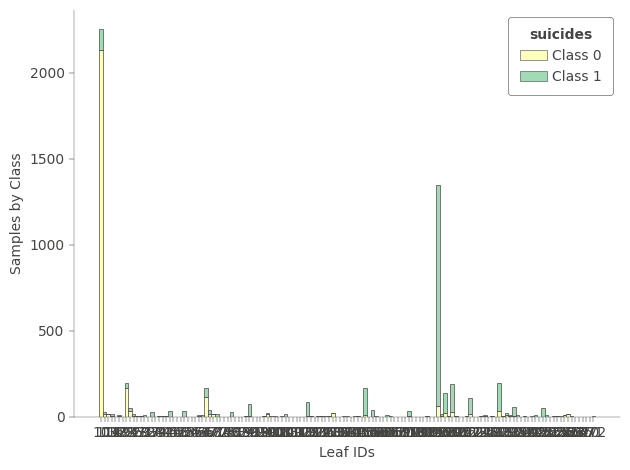

In [47]:
# viz_model.ctree_leaf_distributions()
# plt.tight_layout()
# plt.show()

####Saveing tree graphviz

In [44]:
# file_name = "TREE_" + file_title
# graphviz.Source(dot_graph)
# graphviz.Source(dot_graph).render(file_name, format="svg")
# files.download(file_name + '.svg')